In [15]:
import sys
sys.version

'3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]'

In [1]:
import os
import sklearn
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

tf.random.set_seed(42)

data = '211027_70ms_3ea_Data_2kPa'
dataname = data+'_1'
filename = 'D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/SensorCallbi/LABS_v3/myData/'+data+'.csv'
SD = pd.read_csv(filename)
SD=SD.iloc[:,:28]

In [2]:
SDext =SD # SensorData[SensorData['z']==0]
mask = SDext["z"].isin([10,20,30,40,50,60,70,80,90,100,110,120,130,140,150])
SD = SDext[mask]

In [3]:
import numpy as np
toRad = np.pi/180 
SD['cos']=np.cos(SD.theta_enc*toRad)
SD['sin']=np.sin(SD.theta_enc*toRad)
SD['r'] = (SD['r']-SD['r'].mean())/(SD['r'].max()-SD['r'].min())*2
SD['theta_enc'] = (SD['theta_enc']-SD['theta_enc'].mean())/(SD['theta_enc'].max()-SD['theta_enc'].min())*2
SD['z'] = (SD['z']-SD['z'].mean())/(SD['z'].max()-SD['z'].min())*2

In [4]:
X = SD.iloc[:,:24]
y = SD.iloc[:,[27,28,29]]

In [5]:
y

z       cos       sin
0     -0.999917  1.000000  0.000000
1     -0.999917  1.000000  0.000000
2     -0.999917  1.000000  0.000000
3     -0.999917  1.000000  0.000000
4     -0.999917  1.000000  0.000000
...         ...       ...       ...
69119  1.000083  0.993211 -0.116324
69120  1.000083  0.993211 -0.116324
69121  1.000083  0.993211 -0.116324
69122  1.000083  0.993211 -0.116324
69123  1.000083  0.993211 -0.116324

[69124 rows x 3 columns]

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.001, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)

In [7]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  55243 ea 79 %    X_valid:  13811 ea 19 %    X_test:  70 ea 0 %


In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [9]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/211027_70ms_3ea_Data_2kPa_1_SS.pkl']

In [10]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

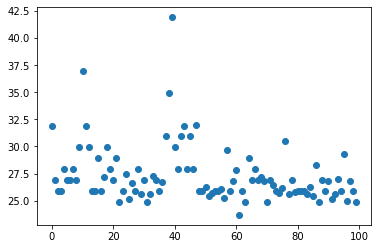

In [14]:
import time
a = np.zeros(100)
for i in range(0,100):
    Prev_time = time.time()
    test_predictions = model.predict(X_test)
    cal_time = round((time.time()-Prev_time)*1000,2)
    a[i] = cal_time
b= range(0,100)
plt.scatter(b,a)

In [38]:
valid_predictions_df=pd.DataFrame(valid_predictions)
valid_predictions_df.columns = ["valid_z","valid_cos","valid_sin"]
#valid_predictions_df.columns = ["valid_r","valid_theta","valid_z"]
#valid_predictions_df.columns = ["valid_cos","valid_sin"]
#valid_predictions_df.columns = ["valid_z"]
#valid_predictions_df.columns = ["valid_theta"]


valid_predictions_df

valid_z  valid_cos  valid_sin
0      0.444848  -0.211655   0.732755
1      0.459638  -0.937481  -0.445313
2      0.192243   0.902067  -0.406652
3     -0.108422   0.780153  -0.739549
4      0.409220  -0.878284   0.425604
...         ...        ...        ...
13806 -0.576871   0.956595   0.360606
13807 -0.415338   0.409459   0.935626
13808 -0.486547   0.010950   1.000949
13809  0.209138   0.294899   0.962850
13810 -0.403330  -0.621319   0.664127

[13811 rows x 3 columns]

In [39]:
k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
k_df.columns  = ["z","cos","sin"]
#k_df.columns = ["r","theta_enc","z"]
#k_df.columns  = ["cos","sin"]
#k_df.columns  = ["z"]
#k_df.columns  = ["theta_enc"]
k_df

z       cos       sin
0     -0.285632 -0.724292  0.689493
1      0.285797 -0.952129 -0.305695
2      0.000083  0.861629 -0.507538
3      0.142940  0.811370 -0.584533
4      0.285797 -0.930737  0.365689
...         ...       ...       ...
13806 -0.714203  0.931881  0.362763
13807 -0.285632  0.416439  0.909163
13808 -0.571346  0.055124  0.998479
13809  0.571511  0.042922  0.999078
13810  0.000083 -0.755739  0.654873

[13811 rows x 3 columns]

In [40]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
for i in range(0,3):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr

corr
89.64% z
86.62% cos
86.53% sin


z       cos       sin   valid_z  valid_cos  valid_sin
z          1.000000 -0.009071  0.006686  0.896375  -0.054039   0.032116
cos       -0.009071  1.000000  0.007548 -0.056225   0.866155   0.056420
sin        0.006686  0.007548  1.000000  0.043696   0.048783   0.865341
valid_z    0.896375 -0.056225  0.043696  1.000000  -0.061186   0.040726
valid_cos -0.054039  0.866155  0.048783 -0.061186   1.000000   0.061315
valid_sin  0.032116  0.056420  0.865341  0.040726   0.061315   1.000000

<AxesSubplot:xlabel='sin', ylabel='valid_sin'>

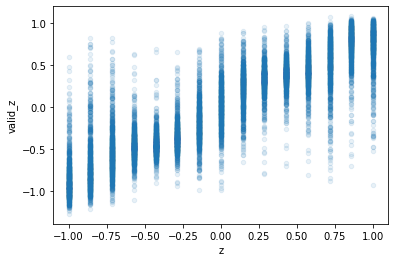

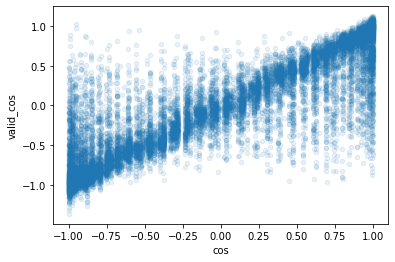

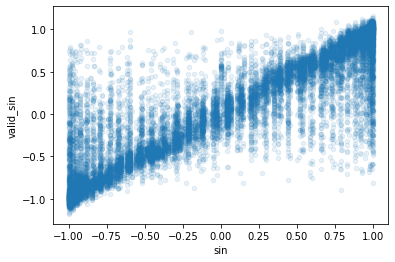

In [41]:
#ValidPre.plot(kind="scatter", x= "r",y= "valid_r",alpha = 0.1)
#ValidPre.plot(kind="scatter", x= "theta_enc",y= "valid_theta",alpha = 0.1)
ValidPre.plot(kind="scatter", x= "z",y= "valid_z",alpha = 0.1)
ValidPre.plot(kind="scatter", x= "cos",y= "valid_cos",alpha = 0.1)
ValidPre.plot(kind="scatter", x= "sin",y= "valid_sin",alpha = 0.1)
#plt.savefig('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/SensorCallbi/LABS_v3/savefig/210903_70ms_3ea_sin.png')